In [1]:
import pandas as pd
import numpy as np
import orbit
from orbit.models import ETS
from orbit.models import DLT
from orbit.diagnostics.backtest import BackTester
from orbit.models import KTR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
file_path = '../data/owid-covid-data.csv'
date_column = 'date'
target_column = 'new_deaths'
df = pd.read_csv(file_path)
df = df[[date_column, target_column,'icu_patients', 'new_tests', 'hosp_patients', 'reproduction_rate']]
df = df.groupby(date_column).sum().reset_index()
df = df.dropna()
df[date_column] = pd.to_datetime(df.pop(date_column), format='%Y-%m-%d')
#df.set_index(date_time, inplace=True, drop=False)

train = df.iloc[:-30]
valid = df.iloc[-30:]

In [3]:
ets = ETS(date_col=date_column, 
          response_col=target_column, 
          prediction_percentiles=[5, 95],
          seed=1)
train.columns
param_grid = {
    "seasonality": [7, 30, 90, 180, 360],
    'level_sm_input': [0.3, 0.5, 0.8],
    'seasonality_sm_input': [0.3, 0.5, 0.8],
}

In [4]:
from orbit.utils.params_tuning import grid_search_orbit
min_train_len = 365 # in case of rolling window, this specify the length of window length
forecast_len = 30 # length forecast window
incremental_len = 30 # step length for moving forward
best_params, tuned_df = grid_search_orbit(
    param_grid,
    model=ets,
    df=df,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    metrics=None,
    criteria="min",
    verbose=False,
)

Widget Javascript not detected.  It may not be installed or enabled properly.


AttributeError: 'FloatProgress' object has no attribute 'style'

In [4]:
train_ets = train[[date_column,target_column]].copy()

ets.fit(df=train_ets)

2023-10-26 17:35:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
Widget Javascript not detected.  It may not be installed or enabled properly.


In [5]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()
forecast_df = valid[[date_column]]
p = ets.predict(df=forecast_df)
p = p.merge(valid, on=date_column, how='left')

print(wmape(p[target_column], p['prediction']))

2.800629743720699


Exception ignored in: <function tqdm.__del__ at 0x7fcddd9a0e50>
Traceback (most recent call last):
  File "/home/sambros/.local/lib/python3.8/site-packages/tqdm/std.py", line 1149, in __del__
    self.close()
  File "/home/sambros/.local/lib/python3.8/site-packages/tqdm/notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
  File "/home/sambros/.local/lib/python3.8/site-packages/tqdm/notebook.py", line 150, in display
    d = self.format_dict
  File "/home/sambros/.local/lib/python3.8/site-packages/tqdm/std.py", line 1463, in format_dict
    'colour': self.colour}
  File "/home/sambros/.local/lib/python3.8/site-packages/tqdm/notebook.py", line 194, in colour
    return self.container.children[-2].style.bar_color
AttributeError: 'FloatProgress' object has no attribute 'style'


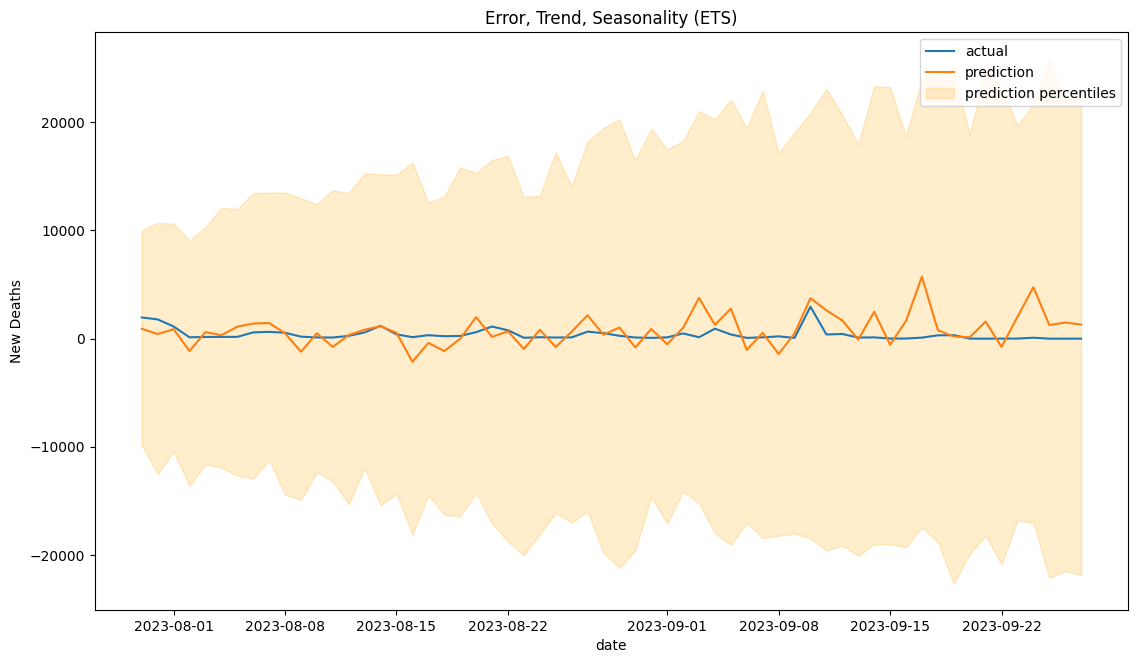

In [6]:
fig, ax = plt.subplots(1,1, figsize=(1280/96, 720/96))
ax.plot(p[date_column], p[target_column], label='actual')
ax.plot(p[date_column], p['prediction'], label='prediction')
ax.fill_between(p[date_column], p['prediction_5'], p['prediction_95'], alpha=0.2, color='orange', label='prediction percentiles')
ax.set_title('Error, Trend, Seasonality (ETS)')
ax.set_ylabel('New Deaths')
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [7]:
p[target_column].mean()
rmse=sqrt(mean_squared_error(p['prediction'],p[target_column]))
print(rmse)


1491.3980318060642


In [8]:
scores = dict()
for global_trend_option in ['linear', 'loglinear', 'flat', 'logistic']:
    dlt = DLT(date_col=date_column, 
            response_col=target_column, 
            seasonality=7,
            prediction_percentiles=[5, 95],
            regressor_col=['icu_patients'],
            regressor_sign=['='],
            regression_penalty='auto_ridge',
            damped_factor=0.8,
            seed=2, # if you get errors due to less than zero values, try a different seed
            global_trend_option=global_trend_option,
            verbose=False)

    bt = BackTester(df=train, 
                    model=dlt, 
                    forecast_len=90,
                    n_splits=5,
                    window_type='rolling')

    bt.fit_predict()
    predicted_df = bt.get_predicted_df()

    scores[global_trend_option] = wmape(predicted_df['actual'], predicted_df['prediction'])

In [9]:
best_global_trend_option = min(scores, key=scores.get)    

dlt = DLT(date_col=date_column, 
        response_col=target_column, 
        seasonality=7,
        prediction_percentiles=[5, 95],
        regressor_col=['icu_patients'],
        regressor_sign=['='],
        regression_penalty='auto_ridge',
        damped_factor=0.8,
        seed=2, # if you get errors due to less than zero values, try a different seed
        global_trend_option=best_global_trend_option,
        verbose=False)

dlt.fit(df=train)

In [10]:
p = dlt.predict(df=valid[[date_column, 'icu_patients']])
p = p.merge(valid, on=date_column, how='left')

print(wmape(p[target_column], p['prediction']))

1.9782085036259203


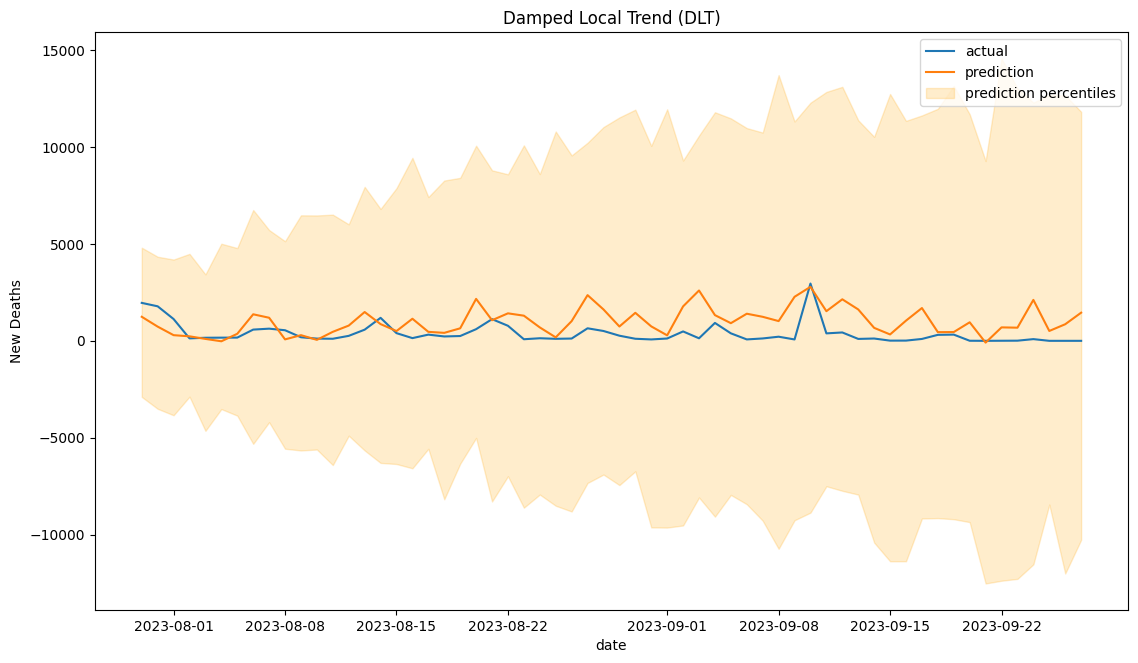

In [11]:
fig, ax = plt.subplots(1,1, figsize=(1280/96, 720/96))
ax.plot(p[date_column], p[target_column], label='actual')
ax.plot(p[date_column], p['prediction'], label='prediction')
ax.fill_between(p[date_column], p['prediction_5'], p['prediction_95'], alpha=0.2, color='orange', label='prediction percentiles')
ax.set_title('Damped Local Trend (DLT)')
ax.set_ylabel('New Deaths')
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [12]:
p[target_column].mean()
rmse=sqrt(mean_squared_error(p['prediction'],p[target_column]))
print(rmse)


954.582369997613


In [13]:
ktr = KTR(date_col=date_column, 
        response_col=target_column, 
        seasonality=[7, 28],
        prediction_percentiles=[5, 95],
        regressor_col=['icu_patients'],
        seed=2,
        verbose=False)

ktr.fit(df=train)

p = ktr.predict(df=valid[[date_column, 'icu_patients']])
p = p.merge(valid, on=date_column, how='left')

print(wmape(p[target_column], p['prediction']))

2023-10-26 17:40:57 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
/home/sambros/.local/lib/python3.8/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
/home/sambros/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to ru

5.036288005308185


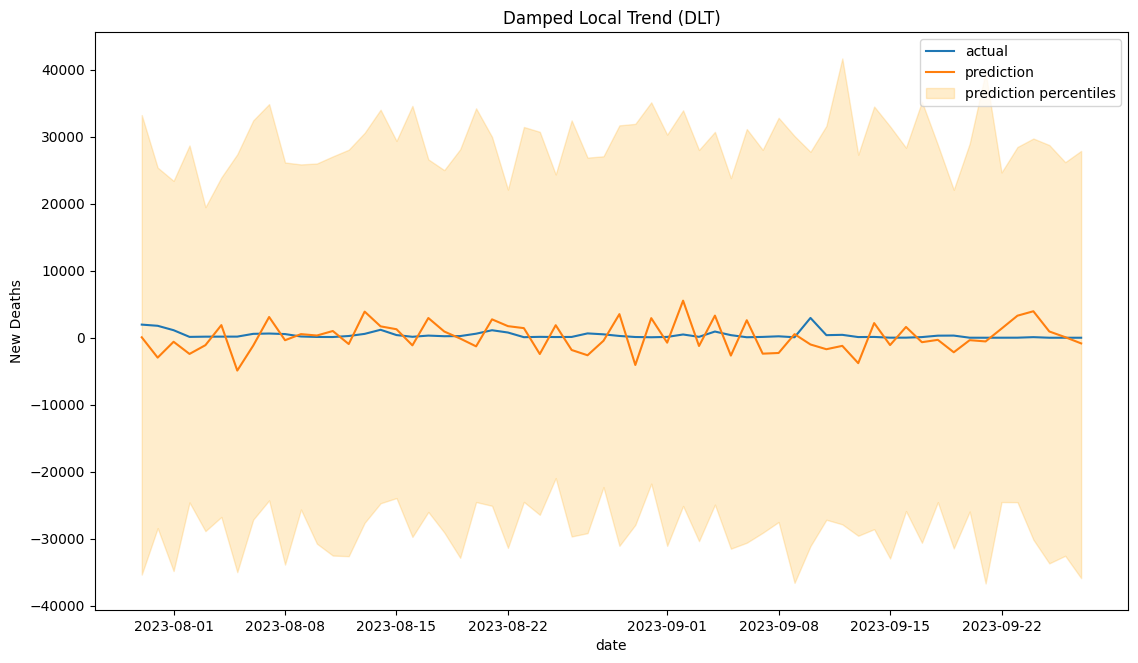

In [14]:
fig, ax = plt.subplots(1,1, figsize=(1280/96, 720/96))
ax.plot(p[date_column], p[target_column], label='actual')
ax.plot(p[date_column], p['prediction'], label='prediction')
ax.fill_between(p[date_column], p['prediction_5'], p['prediction_95'], alpha=0.2, color='orange', label='prediction percentiles')
ax.set_title('Damped Local Trend (DLT)')
ax.set_ylabel('New Deaths')
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [15]:
p[target_column].mean()
rmse=sqrt(mean_squared_error(p['prediction'],p[target_column]))
print(rmse)


2290.6138248488332
